# Little intro about latest incarnation of synphot

From https://synphot.readthedocs.io/en/latest/synphot/overview.html#synphot-models-overview

There are two basic kinds of spectra in synphot, those with and without flux units. The former is used to construct Source Spectrum and Observation, while the latter for Bandpass, extinction curve, and Thermal. In the center of them all are Astropy models, which are used to represent the data, to create composite spectra, and to evaluate the results.

For simplicity and to be consistent with ASTROLIB PYSYNPHOT, a spectrum object stores its wavelength internally in Angstrom. A source spectrum stores flux in PHOTLAM, while a unitless spectrum stores throughput as dimensionless_unscaled. Despite this, most of the functionalities in synphot are unit-aware; i.e., you can pass in Quantity and specify the desired output units via optional keywords (see relevant API documentation).

File I/O in synphot is handled by its specio module, which uses Astropy FITS and Astropy ASCII, but read (both FITS and ASCII) and write (FITS only) spectrum data in a way that is backward-compatible with ASTROLIB PYSYNPHOT. In most cases, this module does not need to be accessed directly, but rather via from_file() and to_fits() methods of a spectrum object.

In [1]:
import os
from os import listdir
import numpy as np
import synphot as S
from synphot import SourceSpectrum
from synphot.models import BlackBodyNorm1D
from synphot import SpectralElement,Observation,units
from synphot.models import Empirical1D
import astropy.units as u
from synphot import Observation,units
from matplotlib import pyplot as plt
import matplotlib
import pandas as pd

plt.rcParams["figure.figsize"] = (20, 5)


In [2]:
cwd = os.getcwd()
path_StandardStars = cwd+"/StandardStars/"

In [3]:
#JWST primary mirror area
area = 253260. #25.326 m^2



## Start with Vega

from the original file
1774.7418447472853 PHOTLAM

 from converted fluxes
4.747549860060794e-20 FNU
8.871499979079545e-09 FLAM
4747.549860060793 Jy

 from the rebuilt spectra
4.747549860060794e-20 FNU
8.871499979079545e-09 FLAM
4747.549860060793 Jy


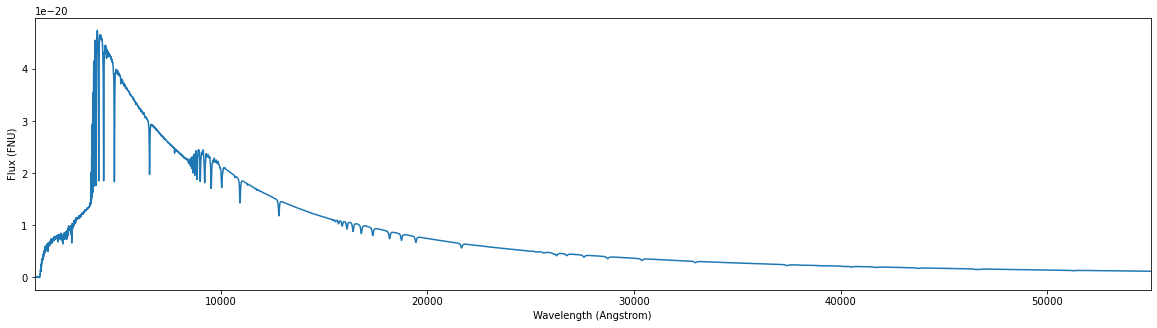

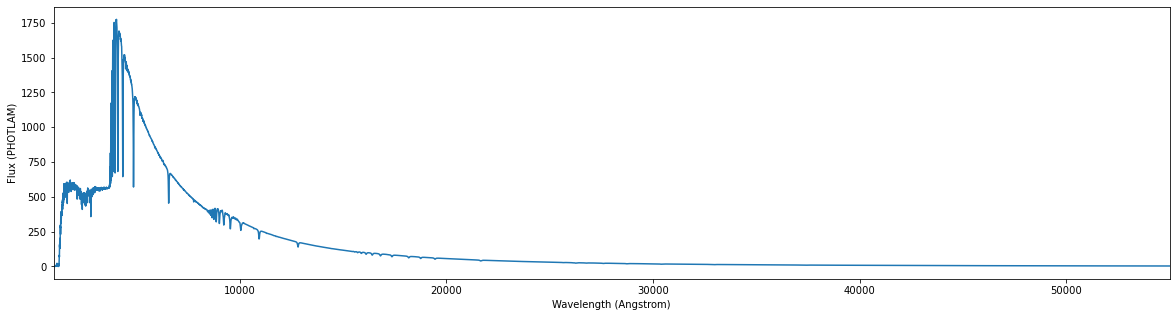

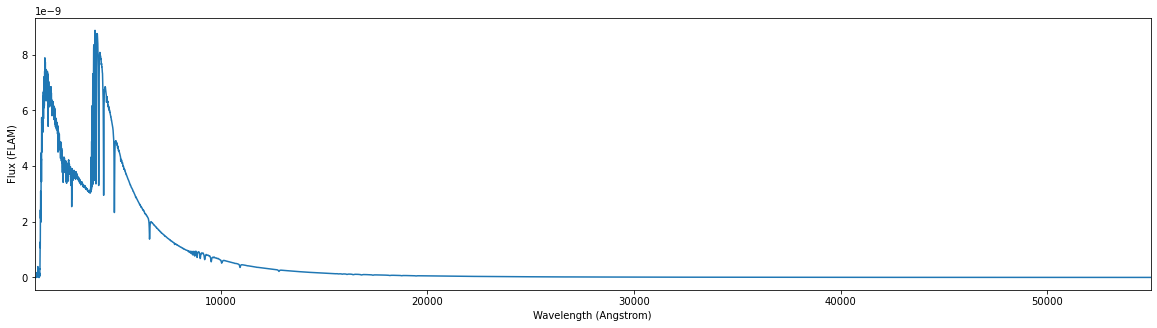

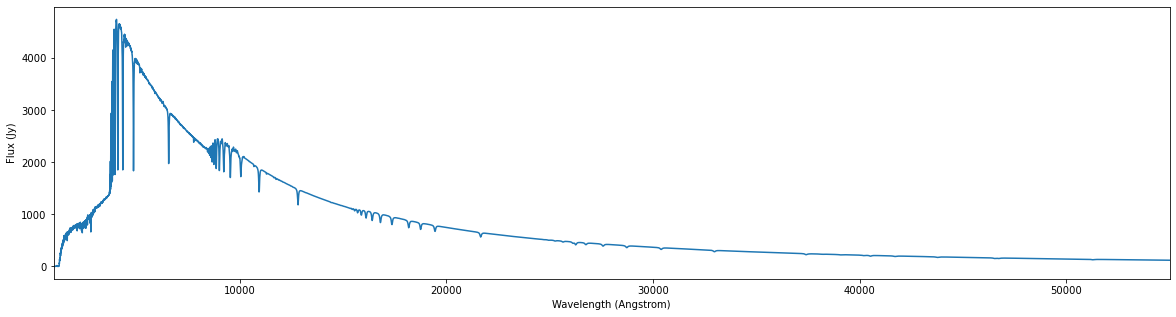

In [4]:
#read our STSDAS vega spectrum 
vega = SourceSpectrum.from_vega() 
# this is a "SourceSpectrum", synphot object, with units...

#... in photlam, the default for SourceSpectrum
print("from the original file")
print(max(vega(vega.waveset)))

#Plot using the SourceSpectrum.plot method, but specifying different flux units
vega.plot(left=1000, right=55000,flux_unit='fnu')
vega.plot(left=1000, right=55000,flux_unit='photlam')
vega.plot(left=1000, right=55000,flux_unit='flam')
vega.plot(left=1000, right=55000,flux_unit='Jy')  #you can see this is a Fnu-type unit 

#However, you may want to work in different units, not just .plot in those units. 
#The problem is that you cannot have a nice SourceSpectum object that is *NOT* in Pholam.
#Something like
#> vega_flam = vega(vega.waveset,flux_units = units.FLAM)
#> print(max(vega_flam))
#could work, but still returns PHOTLAM. 

#Hence here is how one can do it.
#First, convert the flux *arrays* from photlam to fnu, flam, fJy 
vega_fnu=units.convert_flux(vega.waveset,fluxes=vega(vega.waveset),out_flux_unit='fnu')
vega_flam=units.convert_flux(vega.waveset,fluxes=vega(vega.waveset),out_flux_unit='flam')
vega_Jy=units.convert_flux(vega.waveset,fluxes=vega(vega.waveset),out_flux_unit='Jy')
#check:
print("\n from converted fluxes")
print(max(vega_fnu))
print(max(vega_flam))
print(max(vega_Jy))
#ok

#then rebuild the spectra with these these values
vega_fnu = SourceSpectrum(Empirical1D, points=vega.waveset,lookup_table=vega_fnu)
vega_flam = SourceSpectrum(Empirical1D, points=vega.waveset,lookup_table=vega_flam)
vega_Jy = SourceSpectrum(Empirical1D, points=vega.waveset,lookup_table=vega_Jy)

# finally create synphot spectra that have the right flux units. 
vega_fnu=vega_fnu(vega.waveset,flux_unit=units.FNU)
vega_flam=vega_flam(vega.waveset,flux_unit=units.FLAM)
vega_Jy=vega_Jy(vega.waveset,flux_unit=u.Jy)
#check: 
print("\n from the rebuilt spectra")
print(max(vega_fnu))
print(max(vega_flam))
print(max(vega_Jy))

#Note, however, they are not "SourceSpectrum" objects. A good part of the machinery developed for 
#these objects is lost. For example, the basic .plot method does not work anymore:
# vega_Jy.plot() 
#returns an error.

Text(0, 0.5, 'Jy (Flux)')

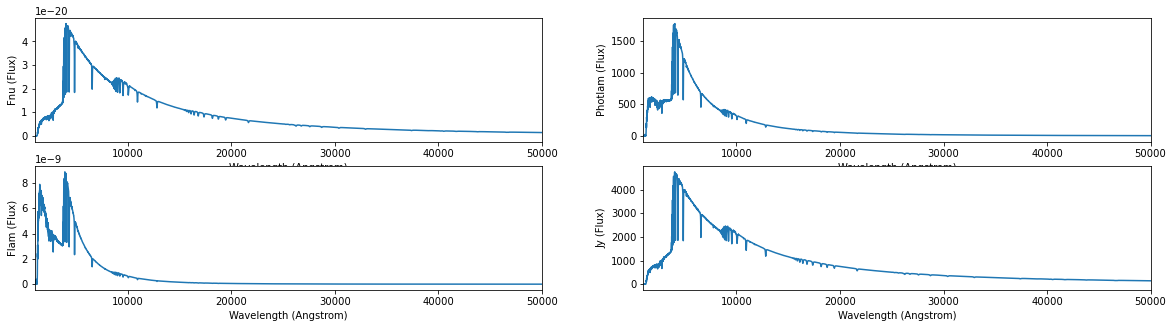

In [5]:
#One can still plot these spectra using regular pyplot, creating for example a more compact 2x2 plot
fig, axs = plt.subplots(2, 2)
wave = vega.waveset
axs[0,0].plot(wave,vega_fnu.value)
axs[0,0].set_xlim(1000, 50000)
axs[0,0].set_xlabel('Wavelength (Angstrom)')
axs[0,0].set_ylabel('Fnu (Flux)')

axs[0,1].plot(wave,vega(wave))   #vega original is still a SourceSpectrum, so I must use vega(wave) instead of vega.value 
axs[0,1].set_xlim(1000, 50000)
axs[0,1].set_xlabel('Wavelength (Angstrom)')
axs[0,1].set_ylabel('Photlam (Flux)')

axs[1,0].plot(wave,vega_flam.value)
axs[1,0].set_xlim(1000, 50000)
axs[1,0].set_xlabel('Wavelength (Angstrom)')
axs[1,0].set_ylabel('Flam (Flux)')

axs[1,1].plot(wave,vega_Jy.value)
axs[1,1].set_xlim(1000, 50000)
axs[1,1].set_xlabel('Wavelength (Angstrom)')
axs[1,1].set_ylabel('Jy (Flux)')

## Black body
### repeat as before... 

from the original file
0.01068014949164188 PHOTLAM

 extracted after converting the flux arrays
3.02785603902453e-25 FNU
6.540609582478353e-14 FLAM
0.030278560390245297 Jy

 from the rebuilt spectra
3.02785603902453e-25 FNU
6.540609582478353e-14 FLAM
0.030278560390245297 Jy


Text(0, 0.5, 'Jy (Flux)')

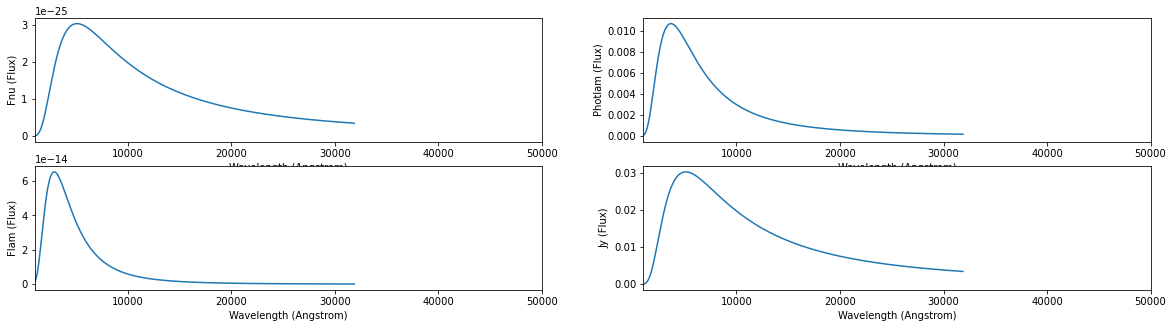

In [6]:

T = 10000
BB = SourceSpectrum(BlackBodyNorm1D, temperature=T)    #as expected, units: A, PHOTLAM
print("from the original file")
print(max(BB(BB.waveset)))    

#Again, to convert the fluxes in fnu, flam, fJy I need to convert/extract, recreate, assign units
#so, 1) convert/extract the arrays in the different units
BB_fnu=units.convert_flux(BB.waveset,fluxes=BB(BB.waveset),out_flux_unit='fnu')
BB_flam=units.convert_flux(BB.waveset,fluxes=BB(BB.waveset),out_flux_unit='flam')
BB_Jy=units.convert_flux(BB.waveset,fluxes=BB(BB.waveset),out_flux_unit='Jy')
#check:
print("\n extracted after converting the flux arrays")
print(max(BB_fnu))
print(max(BB_flam))
print(max(BB_Jy))

#2) rebuild the spectra in these different units, but being SourceSpectrum it still thiks they are PHOTLAM
BB_fnu = SourceSpectrum(Empirical1D, points=BB.waveset,lookup_table=BB_fnu)
BB_flam = SourceSpectrum(Empirical1D, points=BB.waveset,lookup_table=BB_flam)
BB_Jy = SourceSpectrum(Empirical1D, points=BB.waveset,lookup_table=BB_Jy)

#3) create synphot spectra in the right units, but no more SourceSpectrum objects
BB_fnu = BB_fnu(BB.waveset,flux_unit=units.FNU)    #force the units to be FNU
BB_flam = BB_flam(BB.waveset,flux_unit=units.FLAM) #force the units to be FLAM
BB_Jy = BB_Jy(BB.waveset,flux_unit=u.Jy)  #force the units to be Jy

#check: 
print("\n from the rebuilt spectra")
print(max(BB_fnu))
print(max(BB_flam))
print(max(BB_Jy))

# a more compact 2x2 plot
fig, axs = plt.subplots(2, 2)
wave = BB.waveset
axs[0,0].plot(wave,BB_fnu.value)
axs[0,0].set_xlim(1000, 50000)
axs[0,0].set_xlabel('Wavelength (Angstrom)')
axs[0,0].set_ylabel('Fnu (Flux)')

axs[0,1].plot(wave,BB(wave))    
axs[0,1].set_xlim(1000, 50000)
axs[0,1].set_xlabel('Wavelength (Angstrom)')
axs[0,1].set_ylabel('Photlam (Flux)')

axs[1,0].plot(wave,BB_flam.value)
axs[1,0].set_xlim(1000, 50000)
axs[1,0].set_xlabel('Wavelength (Angstrom)')
axs[1,0].set_ylabel('Flam (Flux)')

axs[1,1].plot(wave,BB_Jy.value)
axs[1,1].set_xlim(1000, 50000)
axs[1,1].set_xlabel('Wavelength (Angstrom)')
axs[1,1].set_ylabel('Jy (Flux)')

### So, if you want to use SourceSpectrum objects, you are stuck with Photlam units; if you want to work with other units, e.g. the native ones of your spectrum taken e.g. from the literature, you loose the SourceSpectrum machinery. Synphot uses Photlam and you convert only when needed, at the end...

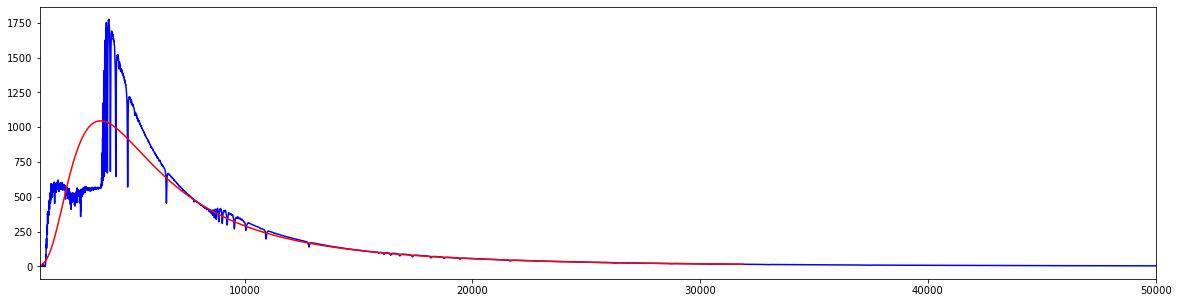

In [7]:
#So let's work in photlam units.

#Let's compare Vega vs a normalized BB; I choose to normalize the K band. 
bp = SpectralElement.from_filter('johnson_k')  
#  apparenty you can only normalize the original spectrum in Photlam, otherwise it does not work... 
BB_norm = BB.normalize(0.00 * units.VEGAMAG, bp, vegaspec=vega) 

plt.xlim(1000, 50000)
plt.plot(vega.waveset, vega(vega.waveset), 'b',BB_norm.waveset, BB_norm(BB_norm.waveset), 'r')  

#Open questions:
#a) why the BB spectrum provided by synphot stops at 31875.492 A? 
#   check:
#   max(BB.waveset)
#b) how to divide two SourceSpectrum objects without having division by 0 errors?

# OK, let's move on. Get the filter list

In [8]:
from os import listdir

filters_directory = cwd + "/nircam_throughputs/modB/nrc_plus_ote"
files_dir =  listdir(filters_directory)
filter_file = []
filters = []
for names in files_dir:
    if names.endswith("sorted.txt"):
        filter_file.append(names)
        filters.append(names[0:5])        
#print(filter_file,filters)

## P330E - Bohlin

In [9]:
#P330e_file = path_StandardStars + "p330e_mod_004.fits"
P330e_file = path_StandardStars + "p330e_stiswfcnic_003.fits"
sp_P330e = SourceSpectrum.from_file(P330e_file,flux_unit='flam') 

In [10]:
d = []  #used later for Pandas table

for i in range(len(filters)):
    bp = SpectralElement.from_file(filters_directory+'/'+filter_file[i])
    bp.waveset.to(u.micron)
    #convoluted way to change the wl units from micron to A. There must be an easier way!
    wl = bp.waveset * 1E4 
    th = bp.model.lookup_table
    Filter = SpectralElement(Empirical1D, points=wl, lookup_table=th, keep_neg=True)

#    Filter.plot(left=1000, right=55000)

    area = 25*1E4 * units.AREA
    binset = range(5000, 55001)

    obs_P330e_Filter = Observation(sp_P330e, Filter, binset=binset)
    binflux = obs_P330e_Filter.sample_binned(flux_unit='count', area=area)
    # Sample the "native" flux for comparison
    flux = obs_P330e_Filter(binset, flux_unit='count', area=area)
    flux_sum = flux.sum()
#    print(flux_sum)

    obs_vega_Filter = Observation(vega, Filter, binset=binset)
    binflux = obs_vega_Filter.sample_binned(flux_unit='count', area=area)
    # Sample the "native" flux for comparison
    flux_Vega = obs_vega_Filter(binset, flux_unit='count', area=area)
    flux_Vega_sum = flux_Vega.sum()

    mag_P330e_Filter = -2.5 * np.log10(flux_sum/flux_Vega_sum)
#    print(filters[i],np.round(flux_sum,2),' VegaMag = ',np.round(mag_P330e_Filter,4))
    
#Other parameters
#    print("pivot wl:",np.round(obs_P330e_Filter.pivot(),2),"   effective wl:",np.round(obs_P330e_Filter.effective_wavelength(),2))
    
# Prepare Pandas table    
    d.append((filters[i],np.round(flux_sum,2),np.round(mag_P330e_Filter,4),np.round(obs_P330e_Filter.pivot(),2),np.round(obs_P330e_Filter.effective_wavelength(),2)))

#Create Pandas table, out of the loop
P330e_table  = pd.DataFrame(d,columns=('Filter','Counts/s','VegaMag','pivol wl','effective wl'))        

In [11]:
P330e_table

,Filter,Counts/s,VegaMag,pivol wl,effective wl
0,F070W,503584.48 ct,12.4553,7019.55 Angstrom,7036.19 Angstrom
1,F090W,809388.26 ct,12.1571,8974.21 Angstrom,8995.16 Angstrom
2,F115W,866601.66 ct,11.9029,11481.23 Angstrom,11508.88 Angstrom
3,F140M,475836.37 ct,11.6197,14028.27 Angstrom,14035.43 Angstrom
4,F150W,3265425.07 ct,11.6372,15045.43 Angstrom,15458.18 Angstrom
5,F150W,1018804.73 ct,11.5465,14918.67 Angstrom,14950.99 Angstrom
6,F162M,462637.48 ct,11.4512,16239.9 Angstrom,16247.92 Angstrom
7,F164N,52996.66 ct,11.4168,16443.54 Angstrom,16443.81 Angstrom
8,F182M,533197.22 ct,11.4231,18378.32 Angstrom,18392.53 Angstrom
9,F187N,47368.91 ct,11.3971,18738.54 Angstrom,18738.91 Angstrom


from the original file
0.00671075504516697 PHOTLAM

 from converted fluxes
3.1839644573588257e-25 FNU
2.658499979944599e-14 FLAM
0.031839644573588254 Jy

 from the rebuilt spectra
3.1839644573588257e-25 FNU
8.871499979079545e-09 FLAM
0.031839644573588254 Jy


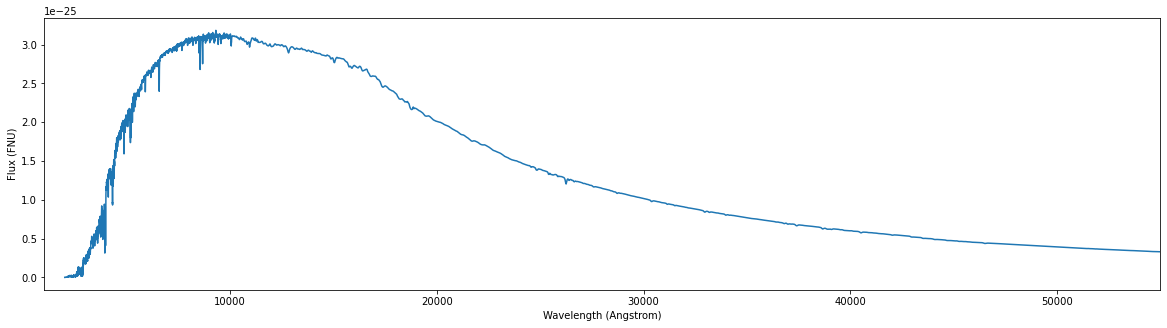

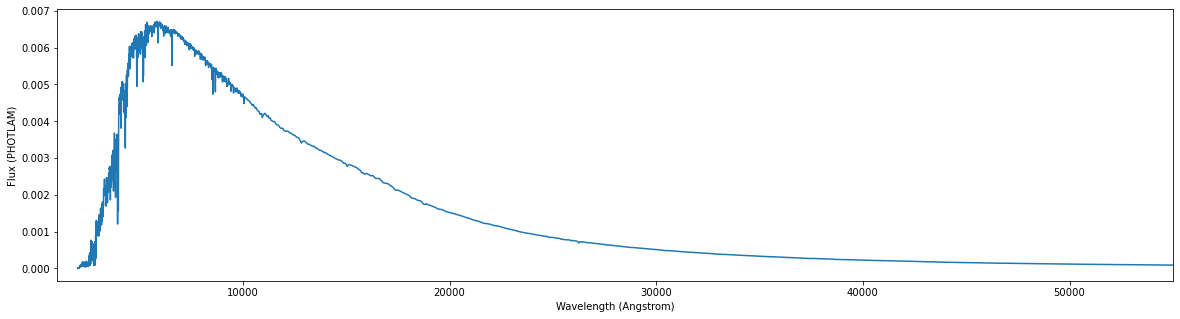

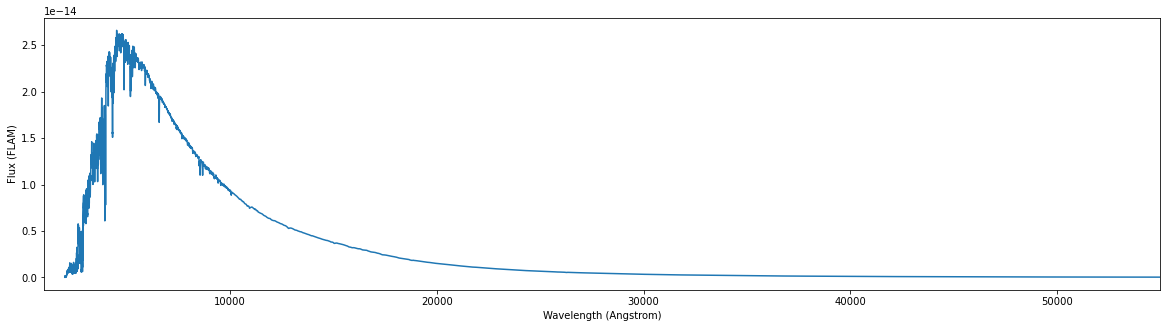

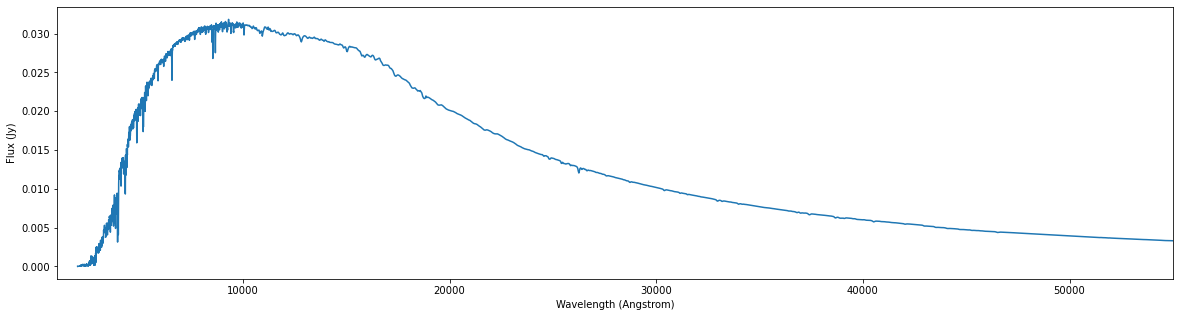

In [12]:
#... in photlam. This is the default for SourceSpectrum
print("from the original file")
print(max(sp_P330e(sp_P330e.waveset)))

#plot using the SourceSpectrum.plot method, specifying different flux units
sp_P330e.plot(left=1000, right=55000,flux_unit='fnu')
sp_P330e.plot(left=1000, right=55000,flux_unit='photlam')
sp_P330e.plot(left=1000, right=55000,flux_unit='flam')
sp_P330e.plot(left=1000, right=55000,flux_unit='Jy')  #this is a Fnu-type unit

#Convert the flux *arrays* from photlam to fnu, flam, fJy 
sp_P330e_fnu=units.convert_flux(sp_P330e.waveset,fluxes=sp_P330e(sp_P330e.waveset),out_flux_unit='fnu')
sp_P330e_flam=units.convert_flux(sp_P330e.waveset,fluxes=sp_P330e(sp_P330e.waveset),out_flux_unit='flam')
sp_P330e_Jy=units.convert_flux(sp_P330e.waveset,fluxes=sp_P330e(sp_P330e.waveset),out_flux_unit='Jy')
#check:
print("\n from converted fluxes")
print(max(sp_P330e_fnu))
print(max(sp_P330e_flam))
print(max(sp_P330e_Jy))
#ok

#then I rebuild the spectra with these these values
sp_P330e_fnu = SourceSpectrum(Empirical1D, points=sp_P330e.waveset,lookup_table=sp_P330e_fnu)
sp_P330e_flam = SourceSpectrum(Empirical1D, points=sp_P330e.waveset,lookup_table=sp_P330e_flam)
sp_P330e_Jy = SourceSpectrum(Empirical1D, points=sp_P330e.waveset,lookup_table=sp_P330e_Jy)
# and create synphot spectra that have the right flux units. 
sp_P330e_fnu=sp_P330e_fnu(sp_P330e.waveset,flux_unit=units.FNU)
sp_P330e_flam=sp_P330e_flam(sp_P330e.waveset,flux_unit=units.FLAM)
sp_P330e_Jy=sp_P330e_Jy(sp_P330e.waveset,flux_unit=u.Jy)
#However, they are not "SourceSpectrum" so I think I have lost a good part of the machinery developed for 
#these objects, pretty bad. 
#check: 
print("\n from the rebuilt spectra")
print(max(sp_P330e_fnu))
print(max(vega_flam))
print(max(sp_P330e_Jy))


Text(0, 0.5, 'Jy (Flux)')

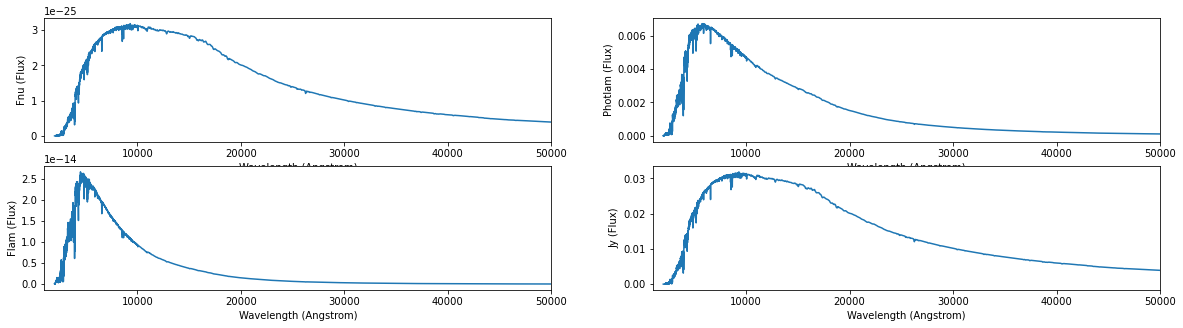

In [13]:
# a more compact 2x2 plot
fig, axs = plt.subplots(2, 2)
wave = sp_P330e.waveset
axs[0,0].plot(wave,sp_P330e_fnu.value)
axs[0,0].set_xlim(1000, 50000)
axs[0,0].set_xlabel('Wavelength (Angstrom)')
axs[0,0].set_ylabel('Fnu (Flux)')

axs[0,1].plot(wave,sp_P330e(wave))    
axs[0,1].set_xlim(1000, 50000)
axs[0,1].set_xlabel('Wavelength (Angstrom)')
axs[0,1].set_ylabel('Photlam (Flux)')

axs[1,0].plot(wave,sp_P330e_flam.value)
axs[1,0].set_xlim(1000, 50000)
axs[1,0].set_xlabel('Wavelength (Angstrom)')
axs[1,0].set_ylabel('Flam (Flux)')

axs[1,1].plot(wave,sp_P330e_Jy.value)
axs[1,1].set_xlim(1000, 50000)
axs[1,1].set_xlabel('Wavelength (Angstrom)')
axs[1,1].set_ylabel('Jy (Flux)')

## P177D - Bohlin

In [14]:
#P177d_file = path_StandardStars + "p177d_mod_003.fits"
P177d_file = path_StandardStars + "p177d_stisnic_008.fits"
sp_P177d = SourceSpectrum.from_file(P177d_file)

In [15]:
d = []  #used later for Pandas table

for i in range(len(filters)):
    bp = SpectralElement.from_file(filters_directory+'/'+filter_file[i])
    bp.waveset.to(u.micron)
    #convoluted way to change the wl units from micron to A. There must be an easier way!
    wl = bp.waveset * 1E4
    th = bp.model.lookup_table
    Filter = SpectralElement(Empirical1D, points=wl, lookup_table=th, keep_neg=True)

    obs_P177d_Filter = Observation(sp_P177d, Filter, binset=binset)
    binflux = obs_P177d_Filter.sample_binned(flux_unit='count', area=area)
    # Sample the "native" flux for comparison
    flux = obs_P330e_Filter(binset, flux_unit='count', area=area)
    flux_sum = flux.sum()

    obs_vega_Filter = Observation(vega, Filter, binset=binset)
    binflux = obs_vega_Filter.sample_binned(flux_unit='count', area=area)
    # Sample the "native" flux for comparison
    flux_Vega = obs_vega_Filter(binset, flux_unit='count', area=area)
    flux_Vega_sum = flux_Vega.sum()

    mag_P177d_Filter = -2.5 * np.log10(flux_sum/flux_Vega_sum)
#    print(filters[i],np.round(flux_sum,2),' VegaMag = ',np.round(mag_P177d_Filter,4))
    
#Other parameters
#    print("pivot wl:",np.round(obs_P177d_Filter.pivot(),2),"   effective wl:",np.round(obs_P177d_Filter.effective_wavelength(),2))
    
# Prepare Pandas table    
    d.append((filters[i],np.round(flux_sum,2),np.round(mag_P177d_Filter,4),np.round(obs_P177d_Filter.pivot(),2),np.round(obs_P177d_Filter.effective_wavelength(),2)))

#Create Pandas table, out of the loop
P177d_table  = pd.DataFrame(d,columns=('Filter','Counts/s','VegaMag','pivol wl','effective wl'))    

In [16]:
P177d_table

,Filter,Counts/s,VegaMag,pivol wl,effective wl
0,F070W,48591.92 ct,14.9941,7019.87 Angstrom,7036.53 Angstrom
1,F090W,48591.92 ct,15.2111,8975.29 Angstrom,8996.28 Angstrom
2,F115W,48591.92 ct,15.0311,11482.99 Angstrom,11510.74 Angstrom
3,F140M,48591.92 ct,14.0969,14028.68 Angstrom,14035.84 Angstrom
4,F150W,48591.92 ct,16.2057,15061.87 Angstrom,15476.68 Angstrom
5,F150W,48591.92 ct,14.8503,14918.64 Angstrom,14950.94 Angstrom
6,F162M,48591.92 ct,13.8979,16239.98 Angstrom,16248.01 Angstrom
7,F164N,48591.92 ct,11.5111,16443.46 Angstrom,16443.72 Angstrom
8,F182M,48591.92 ct,14.0239,18381.23 Angstrom,18395.54 Angstrom
9,F187N,48591.92 ct,11.3694,18738.87 Angstrom,18739.25 Angstrom


from the original file
0.004406896512256337 PHOTLAM

 from converted fluxes
2.0848635315731388e-25 FNU
1.766900055357335e-14 FLAM
0.020848635315731386 Jy

 from the rebuilt spectra
2.0848635315731388e-25 FNU
8.871499979079545e-09 FLAM
0.020848635315731386 Jy


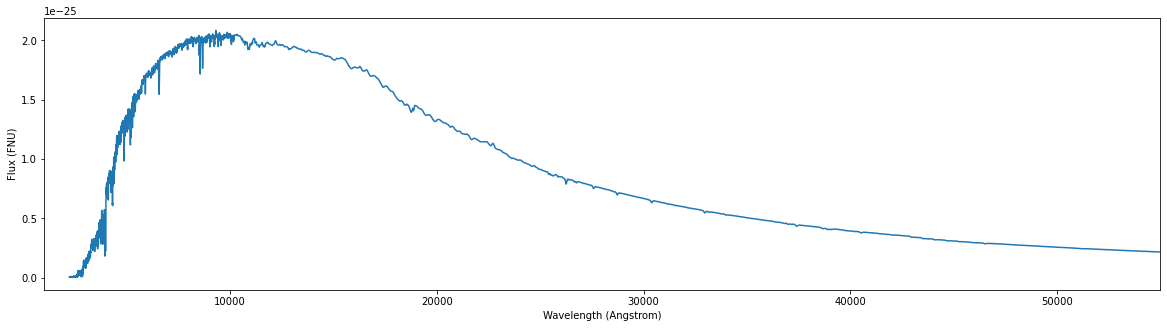

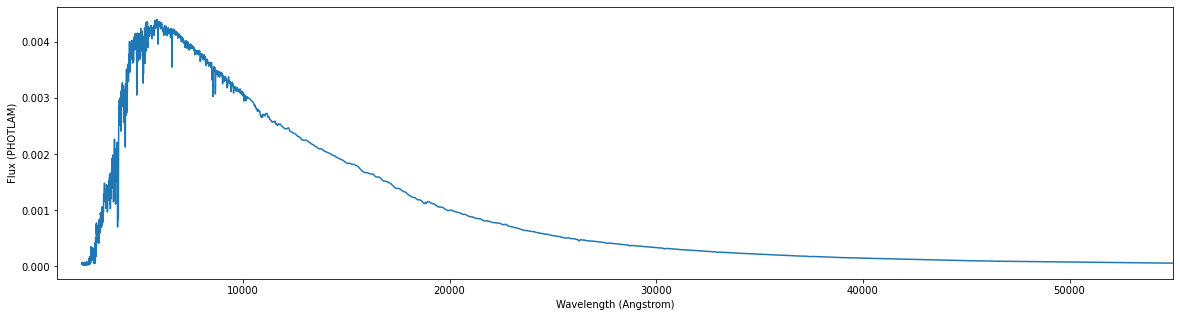

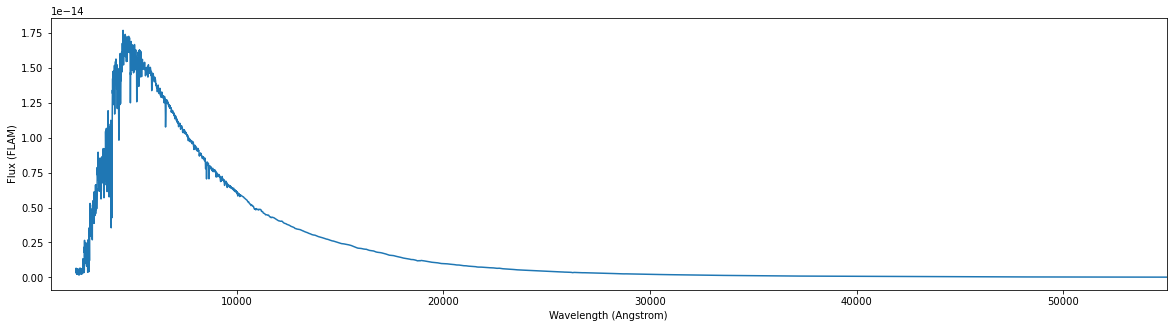

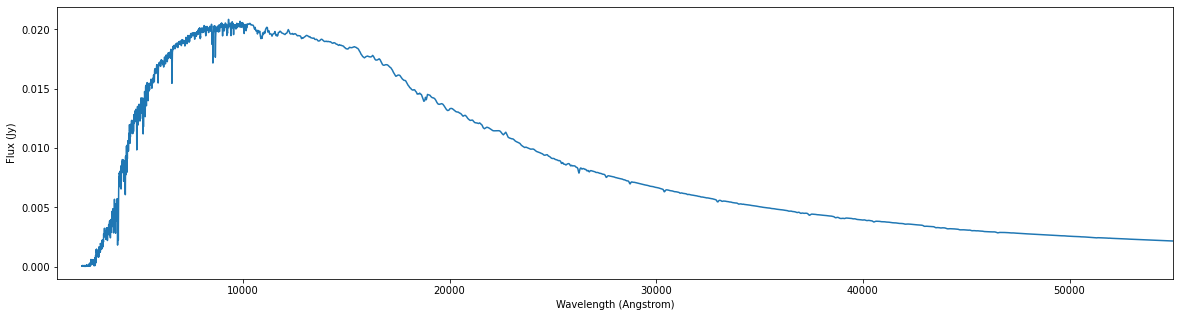

In [17]:
#... in photlam. This is the default for SourceSpectrum
print("from the original file")
print(max(sp_P177d(sp_P177d.waveset)))

#plot using the SourceSpectrum.plot method, specifying different flux units
sp_P177d.plot(left=1000, right=55000,flux_unit='fnu')
sp_P177d.plot(left=1000, right=55000,flux_unit='photlam')
sp_P177d.plot(left=1000, right=55000,flux_unit='flam')
sp_P177d.plot(left=1000, right=55000,flux_unit='Jy')  #this is a Fnu-type unit

#Convert the flux *arrays* from photlam to fnu, flam, fJy 
sp_P177d_fnu=units.convert_flux(sp_P177d.waveset,fluxes=sp_P177d(sp_P177d.waveset),out_flux_unit='fnu')
sp_P177d_flam=units.convert_flux(sp_P177d.waveset,fluxes=sp_P177d(sp_P177d.waveset),out_flux_unit='flam')
sp_P177d_Jy=units.convert_flux(sp_P177d.waveset,fluxes=sp_P177d(sp_P177d.waveset),out_flux_unit='Jy')
#check:
print("\n from converted fluxes")
print(max(sp_P177d_fnu))
print(max(sp_P177d_flam))
print(max(sp_P177d_Jy))
#ok

#then I rebuild the spectra with these these values
sp_P177d_fnu = SourceSpectrum(Empirical1D, points=sp_P177d.waveset,lookup_table=sp_P177d_fnu)
sp_P177d_flam = SourceSpectrum(Empirical1D, points=sp_P177d.waveset,lookup_table=sp_P177d_flam)
sp_P177d_Jy = SourceSpectrum(Empirical1D, points=sp_P177d.waveset,lookup_table=sp_P177d_Jy)
# and create synphot spectra that have the right flux units. 
sp_P177d_fnu=sp_P177d_fnu(sp_P177d.waveset,flux_unit=units.FNU)
sp_P177d_flam=sp_P177d_flam(sp_P177d.waveset,flux_unit=units.FLAM)
sp_P177d_Jy=sp_P177d_Jy(sp_P177d.waveset,flux_unit=u.Jy)
#However, they are not "SourceSpectrum" so I think I have lost a good part of the machinery developed for 
#these objects, pretty bad. 
#check: 
print("\n from the rebuilt spectra")
print(max(sp_P177d_fnu))
print(max(vega_flam))
print(max(sp_P177d_Jy))


Text(0, 0.5, 'Jy (Flux)')

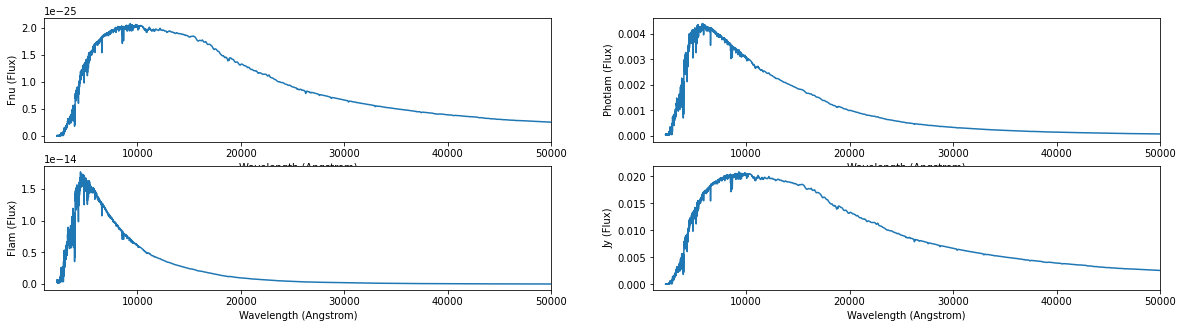

In [18]:
# a more compact 2x2 plot
fig, axs = plt.subplots(2, 2)
wave = sp_P177d.waveset
axs[0,0].plot(wave,sp_P177d_fnu.value)
axs[0,0].set_xlim(1000, 50000)
axs[0,0].set_xlabel('Wavelength (Angstrom)')
axs[0,0].set_ylabel('Fnu (Flux)')

axs[0,1].plot(wave,sp_P177d(wave))    
axs[0,1].set_xlim(1000, 50000)
axs[0,1].set_xlabel('Wavelength (Angstrom)')
axs[0,1].set_ylabel('Photlam (Flux)')

axs[1,0].plot(wave,sp_P177d_flam.value)
axs[1,0].set_xlim(1000, 50000)
axs[1,0].set_xlabel('Wavelength (Angstrom)')
axs[1,0].set_ylabel('Flam (Flux)')

axs[1,1].plot(wave,sp_P177d_Jy.value)
axs[1,1].set_xlim(1000, 50000)
axs[1,1].set_xlabel('Wavelength (Angstrom)')
axs[1,1].set_ylabel('Jy (Flux)')

## Load  Rieke's solar-analog spectrum: "P330e_solar"

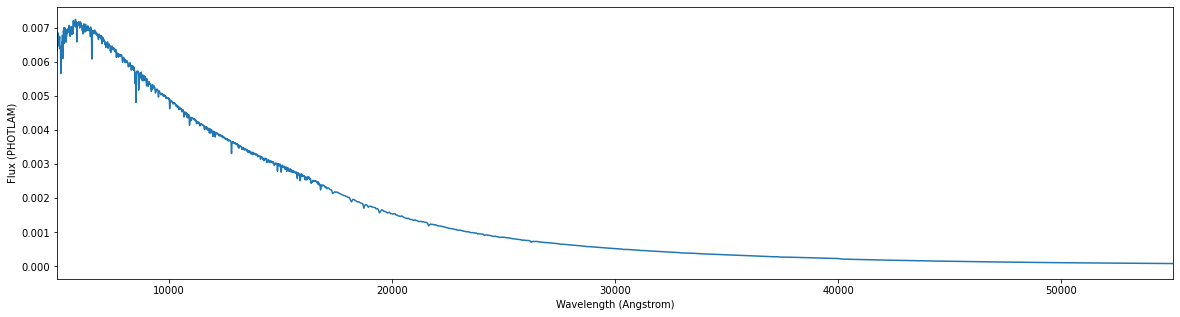

In [19]:
P330e_solar = path_StandardStars + "solar_P330-E_spec.txt"

#Ascii table, import using pandas
table = pd.read_table(P330e_solar,skiprows=1,skipinitialspace=True)

#extract...
wl = table['#lambda(nm)'] * 10   # Angstrom
fl = table['photonsm-2nm-1'] / 1E4 / 10 #FROM u.photon / (u.cm**2 * u.s * u.AA => photlam (ph/m2/nm) 

#create SourceSpectrum object, in Photlam units
sp_P330e_solar = SourceSpectrum(Empirical1D, points=wl.to_numpy(), lookup_table=fl.to_numpy(), keep_neg=True)
sp_P330e_solar.plot(left=5000, right=55000)

In [20]:
d = []  #used later for Pandas table

for i in range(len(filters)):
    bp = SpectralElement.from_file(filters_directory+'/'+filter_file[i])
    bp.waveset.to(u.micron)
    #convoluted way to change the wl units from micron to A. There must be an easier way!
    wl = bp.waveset * 1E4 
    th = bp.model.lookup_table
    Filter = SpectralElement(Empirical1D, points=wl, lookup_table=th, keep_neg=True)

#    Filter.plot(left=1000, right=55000)

    area = 25*1E4 * units.AREA
    binset = range(5000, 55001)

    obs_P330e_solar_Filter = Observation(sp_P330e_solar, Filter, binset=binset)
    binflux = obs_P330e_solar_Filter.sample_binned(flux_unit='count', area=area)
    # Sample the "native" flux for comparison
    flux = obs_P330e_solar_Filter(binset, flux_unit='count', area=area)
    flux_sum = flux.sum()
#    print(flux_sum)

    obs_vega_Filter = Observation(vega, Filter, binset=binset)
    binflux = obs_vega_Filter.sample_binned(flux_unit='count', area=area)
    # Sample the "native" flux for comparison
    flux_Vega = obs_vega_Filter(binset, flux_unit='count', area=area)
    flux_Vega_sum = flux_Vega.sum()

    mag_P330e_solar_Filter = -2.5 * np.log10(flux_sum/flux_Vega_sum)
#    print(filters[i],np.round(flux_sum,2),' VegaMag = ',np.round(mag_P330e_solar_Filter,4))
    
#Other parameters
#    print("pivot wl:",np.round(obs_P330e_solar_Filter.pivot(),2),"   effective wl:",np.round(obs_P330e_solar_Filter.effective_wavelength(),2))
    
# Prepare Pandas table    
    d.append((filters[i],np.round(flux_sum,2),np.round(mag_P330e_solar_Filter,4),np.round(obs_P330e_solar_Filter.pivot(),2),np.round(obs_P330e_solar_Filter.effective_wavelength(),2)))

#Create Pandas table, out of the loop
P330e_solar_table  = pd.DataFrame(d,columns=('Filter','Counts/s','VegaMag','pivol wl','effective wl'))    

P330e_solar_table

,Filter,Counts/s,VegaMag,pivol wl,effective wl
0,F070W,536841.23 ct,12.3859,7016.83 Angstrom,7033.49 Angstrom
1,F090W,849313.2 ct,12.1048,8972.23 Angstrom,8993.19 Angstrom
2,F115W,906178.24 ct,11.8545,11481.31 Angstrom,11509.0 Angstrom
3,F140M,493605.87 ct,11.5799,14027.68 Angstrom,14034.85 Angstrom
4,F150W,3372338.59 ct,11.6022,15006.63 Angstrom,15417.49 Angstrom
5,F150W,1053824.01 ct,11.5098,14914.93 Angstrom,14947.21 Angstrom
6,F162M,475295.16 ct,11.4219,16237.65 Angstrom,16245.65 Angstrom
7,F164N,54113.68 ct,11.3942,16443.65 Angstrom,16443.92 Angstrom
8,F182M,545890.09 ct,11.3976,18377.34 Angstrom,18391.53 Angstrom
9,F187N,48398.85 ct,11.3737,18738.58 Angstrom,18738.96 Angstrom


from the original file
0.0072510000000000005 PHOTLAM

 from converted fluxes
3.31491952935066e-25 FNU
2.872638554395856e-14 FLAM
0.0331491952935066 Jy

 from the rebuilt spectra
3.31491952935066e-25 FNU
2.658499979944599e-14 FLAM
0.0331491952935066 Jy


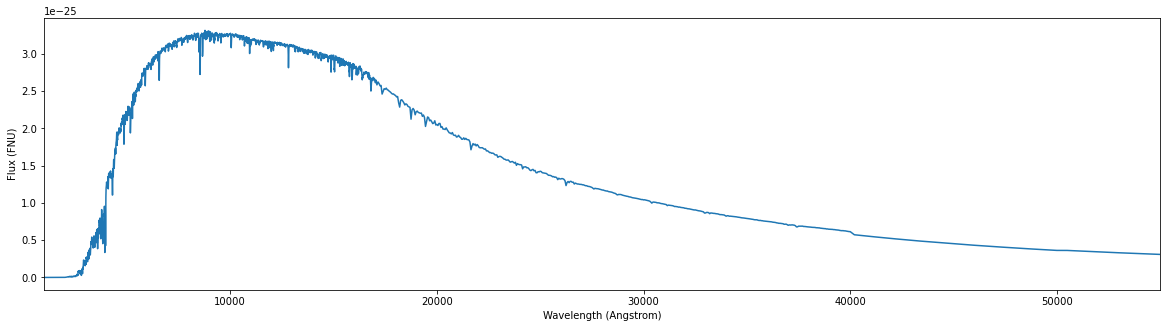

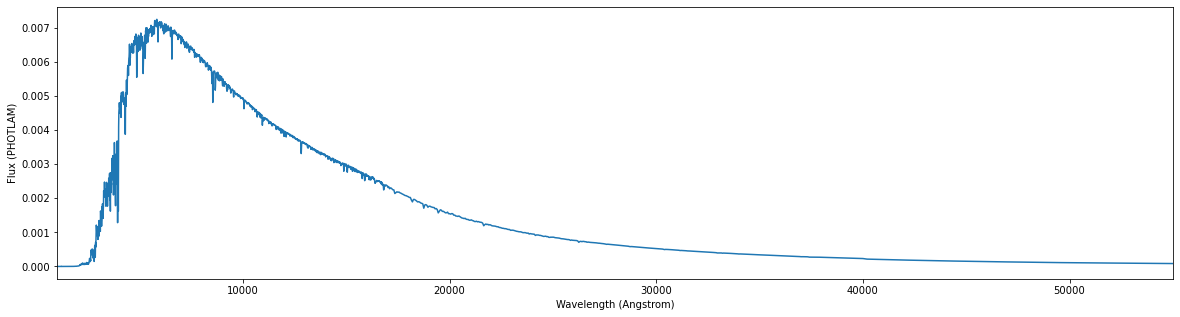

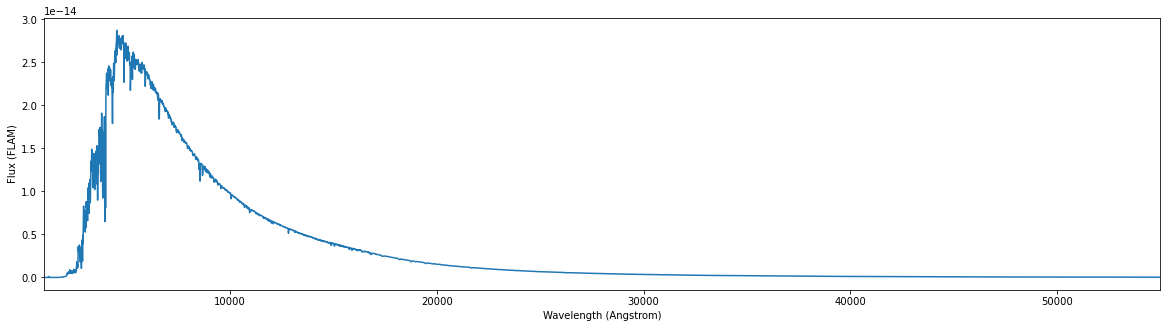

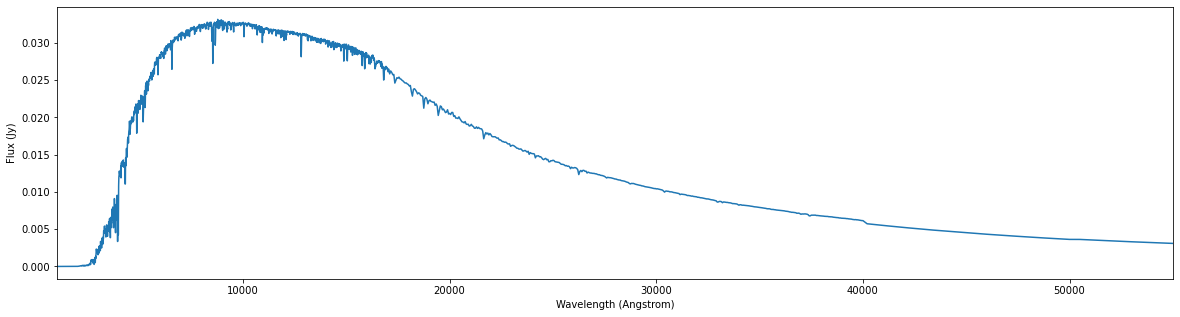

In [21]:
#... in photlam. This is the default for SourceSpectrum
print("from the original file")
print(max(sp_P330e_solar(sp_P330e_solar.waveset)))

#plot using the SourceSpectrum.plot method, specifying different flux units
sp_P330e_solar.plot(left=1000, right=55000,flux_unit='fnu')
sp_P330e_solar.plot(left=1000, right=55000,flux_unit='photlam')
sp_P330e_solar.plot(left=1000, right=55000,flux_unit='flam')
sp_P330e_solar.plot(left=1000, right=55000,flux_unit='Jy')  #this is a Fnu-type unit

#Convert the flux *arrays* from photlam to fnu, flam, fJy 
sp_P330e_solar_fnu=units.convert_flux(sp_P330e_solar.waveset,fluxes=sp_P330e_solar(sp_P330e_solar.waveset),out_flux_unit='fnu')
sp_P330e_solar_flam=units.convert_flux(sp_P330e_solar.waveset,fluxes=sp_P330e_solar(sp_P330e_solar.waveset),out_flux_unit='flam')
sp_P330e_solar_Jy=units.convert_flux(sp_P330e_solar.waveset,fluxes=sp_P330e_solar(sp_P330e_solar.waveset),out_flux_unit='Jy')
#check:
print("\n from converted fluxes")
print(max(sp_P330e_solar_fnu))
print(max(sp_P330e_solar_flam))
print(max(sp_P330e_solar_Jy))
#ok

#then I rebuild the spectra with these these values
sp_P330e_solar_fnu = SourceSpectrum(Empirical1D, points=sp_P330e_solar.waveset,lookup_table=sp_P330e_solar_fnu)
sp_P330e_solar_flam = SourceSpectrum(Empirical1D, points=sp_P330e_solar.waveset,lookup_table=sp_P330e_solar_flam)
sp_P330e_solar_Jy = SourceSpectrum(Empirical1D, points=sp_P330e_solar.waveset,lookup_table=sp_P330e_solar_Jy)
# and create synphot spectra that have the right flux units. 
sp_P330e_solar_fnu=sp_P330e_solar_fnu(sp_P330e_solar.waveset,flux_unit=units.FNU)
sp_P330e_solar_flam=sp_P330e_solar_flam(sp_P330e_solar.waveset,flux_unit=units.FLAM)
sp_P330e_solar_Jy=sp_P330e_solar_Jy(sp_P330e_solar.waveset,flux_unit=u.Jy)
#However, they are not "SourceSpectrum" so I think I have lost a good part of the machinery developed for 
#these objects, pretty bad. 
#check: 
print("\n from the rebuilt spectra")
print(max(sp_P330e_solar_fnu))
print(max(sp_P330e_flam))
print(max(sp_P330e_solar_Jy))


Text(0, 0.5, 'Jy (Flux)')

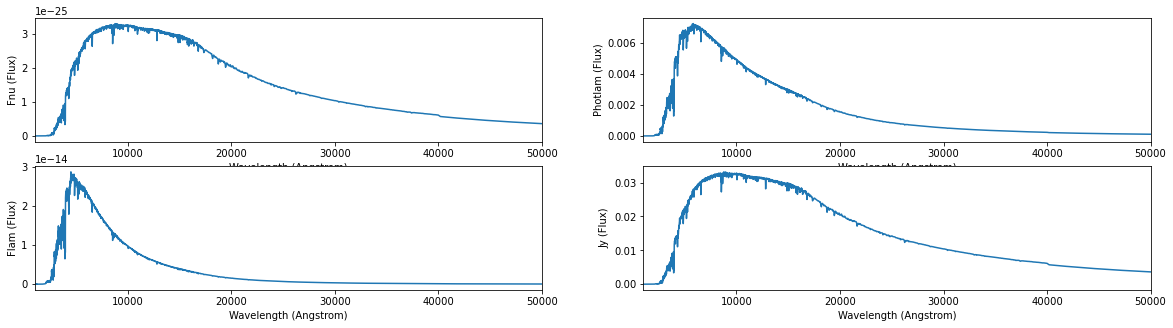

In [22]:
 # a more compact 2x2 plot
fig, axs = plt.subplots(2, 2)
wave = sp_P330e_solar.waveset
axs[0,0].plot(wave,sp_P330e_solar_fnu.value)
axs[0,0].set_xlim(1000, 50000)
axs[0,0].set_xlabel('Wavelength (Angstrom)')
axs[0,0].set_ylabel('Fnu (Flux)')

axs[0,1].plot(wave,sp_P330e_solar(wave))    
axs[0,1].set_xlim(1000, 50000)
axs[0,1].set_xlabel('Wavelength (Angstrom)')
axs[0,1].set_ylabel('Photlam (Flux)')

axs[1,0].plot(wave,sp_P330e_solar_flam.value)
axs[1,0].set_xlim(1000, 50000)
axs[1,0].set_xlabel('Wavelength (Angstrom)')
axs[1,0].set_ylabel('Flam (Flux)')

axs[1,1].plot(wave,sp_P330e_solar_Jy.value)
axs[1,1].set_xlim(1000, 50000)
axs[1,1].set_xlabel('Wavelength (Angstrom)')
axs[1,1].set_ylabel('Jy (Flux)')

## Ratio Bohlin/Rieke

there is some major discrepancy between the two spectra.
Rieke spectrum seems to have a (deeper) drop at about 4micron, visible in the Fnu and FJy plot above

In [23]:
r = sp_P330e/sp_P330e_solar

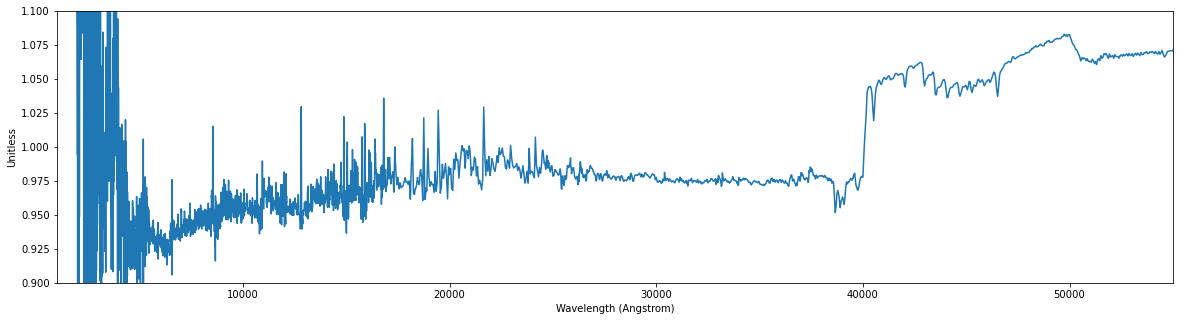

In [24]:
r.plot(left=1000, right=55000, bottom=0.9,top=1.1)

### There is also some serious discrepancy longward than 5 micron...

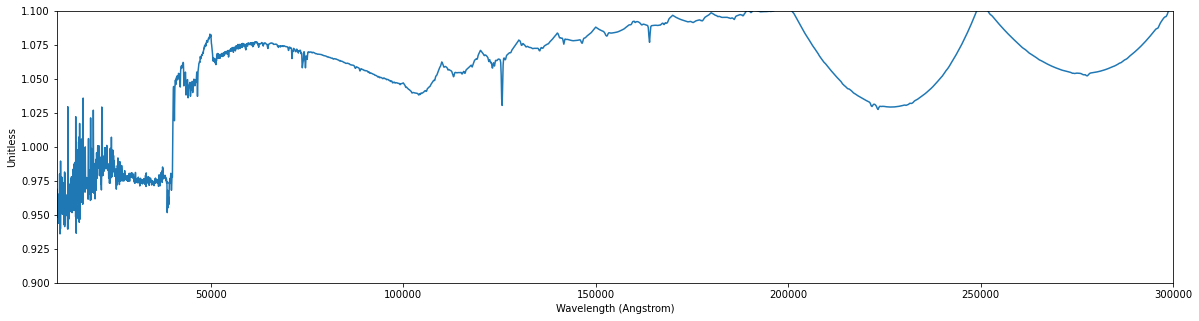

In [25]:
r.plot(left=10000, right=300000, bottom=0.9,top=1.1)

## We can zoom-in by dividing by lambda**3: should be nearly flat at long wl, R.J.

(since B_lambda ~ lambda^-4, Photlam ~ lambda^-3)

In [26]:
# Rieke...
r=sp_P330e_solar(sp_P330e_solar.waveset)*sp_P330e_solar.waveset**3

(10000.0, 10000000.0)

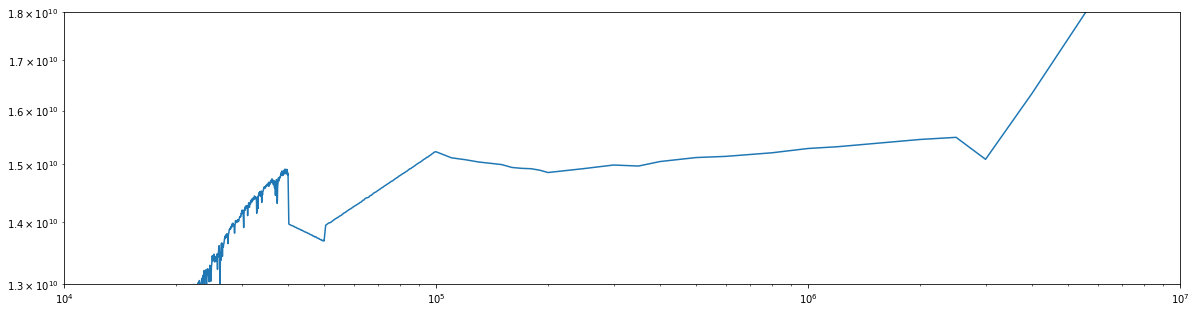

In [27]:
plt.plot(sp_P330e_solar.waveset,r)
plt.xscale('log')
plt.yscale('log')
plt.ylim(1.3E10, 1.8E10)
plt.xlim(1E4, 1E7)

(10000.0, 10000000.0)

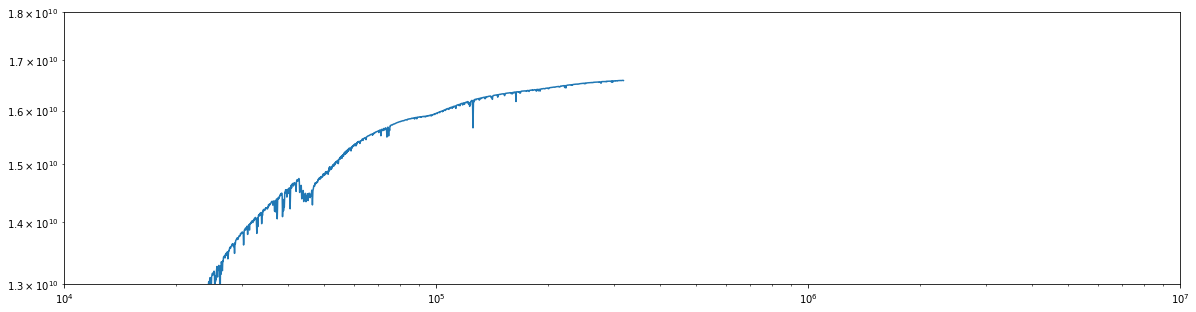

In [28]:
#Vs. Bohlin.... same scale
r=sp_P330e(sp_P330e.waveset)*sp_P330e.waveset**3
plt.plot(sp_P330e.waveset,r)
plt.xscale('log')
plt.yscale('log')
plt.ylim(1.3E10, 1.8E10)
plt.xlim(1E4, 1E7)